# <div style="text-align: center; color: #1a5276;">Differentiation and Gradients</div>

## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)  
3. [Gradient Tape for Differentiation](#3)
6. [Annex](#annex) <br>
    A. [WITH](#A) <br>
7. [References](#references)

<a name="1"></a>
## <font color='blue'> 1. Introduction </font>

In this notebook, we'll explore how to calculate derivatives and gradients using TensorFlow's GradientTape. Understanding these concepts is crucial for machine learning, especially in tasks involving backpropagation and optimization.

<a name="2"></a>
## <font color='blue'> 2. Setup </font>

In [3]:
# seetup
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

<a name="3"></a>
## <font color='blue'> 3. Gradient Tape for Differentiation </font>

Let's explore how you can use [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to do automatic differentiation.

### Example 1

We want to compute the derivative of the function:

$$y = x^2$$

Using calculus, the derivative is:

$$\frac{dy}{dx} = 2x$$

For example, the derivative at x= 5 is 2*5 = 10.


In [5]:
# Define a constant value for x
x = tf.constant(5.0)

# Create a GradientTape context
with tf.GradientTape() as g:
    # Manually watch the constant to track gradients
    g.watch(x)
    
    # Define the function y = x^2
    y = x * x

# Compute the derivative dy/dx
dy_dx = g.gradient(y, x)

# Display the result
print(dy_dx)  # Expected output: 10.0 (since dy/dx = 2x and x = 5)

tf.Tensor(10.0, shape=(), dtype=float32)


### Example 2

By default, the resources held by a GradientTape are released as soon as GradientTape.gradient() method is called.
The following code will raise an exception:

In [6]:
try:
    # Define a constant value for x
    x = tf.constant(3.0)

    # Create a GradientTape context
    with tf.GradientTape() as g:
        g.watch(x)  # Watch the constant to track gradients
        y = x * x   # y = x^2
        z = y * y   # z = (x^2)^2 = x^4

    # Compute dz/dx (should be 4x^3)
    dz_dx = g.gradient(z, x)
    print(f"dz/dx = {dz_dx}")

    # Attempt to compute dy/dx (will raise an error)
    dy_dx = g.gradient(y, x)
    print(f"dy/dx = {dy_dx}")

except Exception as e:
    print(f"An error occurred: {e}")


dz/dx = 108.0
An error occurred: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


The error means you're trying to compute gradients twice using the same GradientTape without setting persistent=True.

Why?
By default, tf.GradientTape is not persistent, meaning it automatically deletes its internal data after calling .gradient() once.
If you need multiple gradient calculations, add persistent=True.

In [7]:
x = tf.constant(3.0)

with tf.GradientTape(persistent=True) as g:
    g.watch(x)
    y = x * x
    z = y * y

dz_dx = g.gradient(z, x)  # (4*x^3 at x = 3)
print(dz_dx)

# now that is persistent we can reuse it
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor(108.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


### Example 3, Nested gradients

Are useful, for example, when you need to calculate higher-order derivatives.


Given the function:

$$y = x^2$$

The first derivative is:

$$\frac{dy}{dx} = 2x$$

The second derivative (derivative of the first derivative) is:

$$\frac{d^2y}{dx^2} = 2$$ 


In [8]:
x = tf.constant(5.0)

with tf.GradientTape() as g:
  g.watch(x)
  with tf.GradientTape() as gg:
    gg.watch(x)
    y = x * x
  dy_dx = gg.gradient(y, x)  # dy_dx = 2 * x

d2y_dx2 = g.gradient(dy_dx, x)  # d2y_dx2 = 2

print(dy_dx)
print(d2y_dx2)

tf.Tensor(10.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


### Example 4,  Gradient of a Scalar Function with Respect to a Tensor

Given the input tensor:

$$
x = \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix}
$$

#### Step 1: Compute \(y\)  
Let \(y\) be the sum of all elements in \(x\):

$$
y = \sum_{i,j} x_{i,j} = 1 + 1 + 1 + 1 = 4
$$

#### Step 2: Compute \(z\)  
Let \(z = y^2\), hence:

$$
z = 4^2 = 16
$$

#### Step 3: Compute the Gradient  
Using the chain rule:

$$
\frac{\partial z}{\partial x_{i,j}} = \frac{\partial z}{\partial y} \cdot \frac{\partial y}{\partial x_{i,j}}
$$

Since:

$$
\frac{\partial z}{\partial y} = 2y \quad \text{and} \quad \frac{\partial y}{\partial x_{i,j}} = 1
$$

The result is:

$$
\frac{\partial z}{\partial x_{i,j}} = 2y \cdot 1 = 2 \times 4 = 8
$$

Thus,

$$
\frac{\partial z}{\partial x} = \begin{bmatrix} 8 & 8 \\ 8 & 8 \end{bmatrix}
$$


In [18]:
# Define a 2x2 array of 1's
x = tf.ones((2,2))

print(f"Input:\n {x}\n")

with tf.GradientTape() as t:
    # Record the actions performed on tensor x with `watch`
    t.watch(x) 

    # Define y as the sum of the elements in x
    y =  tf.reduce_sum(x)
    
    print(f"y:\n {y}\n")

    # Let z be the square of y
    z = tf.square(y)
    
    print(f"z:\n {z}\n")

# Get the derivative of z wrt the original input tensor x
dz_dx = t.gradient(z, x)

# Print our result
print(f"dz_dx:\n {dz_dx}")

Input:
 [[1. 1.]
 [1. 1.]]

y:
 4.0

z:
 16.0

dz_dx:
 [[8. 8.]
 [8. 8.]]


Let's see what happens if we do not use tf.reduce_sum:

### Gradient Without `reduce_sum`

Given the input tensor:

$$
x = \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix}
$$

#### Step 1: Compute \(y\)  
Instead of summing the elements, let \(y = x\), so:

$$
y = \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix}
$$

#### Step 2: Compute \(z\)  
Let \(z = y^2\), hence:

$$
z = \begin{bmatrix} 1^2 & 1^2 \\ 1^2 & 1^2 \end{bmatrix}
=
\begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix}
$$

#### Step 3: Compute the Gradient  
Since \( z = x^2 \), the derivative is:

$$
\frac{\partial z}{\partial x} = 2x
$$

Thus,

$$
\frac{\partial z}{\partial x} = \begin{bmatrix} 2 & 2 \\ 2 & 2 \end{bmatrix}
$$

#### Key Difference
- Using `reduce_sum` results in **all elements being 8**.
- Without `reduce_sum`, the gradient is **2 at every position**.


In [20]:
# Define a 2x2 array of 1's
x = tf.ones((2,2))

print(f"Input:\n {x}\n")

with tf.GradientTape() as t:
    # Record the actions performed on tensor x with `watch`
    t.watch(x) 

    # Let z be the square of y
    z = tf.square(x)
    
    print(f"z:\n {z}\n")

# Get the derivative of z wrt the original input tensor x
dz_dx = t.gradient(z, x)

# Print our result
print(f"dz_dx:\n {dz_dx}")

Input:
 [[1. 1.]
 [1. 1.]]

z:
 [[1. 1.]
 [1. 1.]]

dz_dx:
 [[2. 2.]
 [2. 2.]]


#### Understanding the Difference

In both cases, you are computing gradients, but the operations and their effects differ:

#### 1. With `reduce_sum`
- **What happens?**  
  - The function collapses all elements in the tensor into a **single scalar value** by summing them.  
  - The gradient reflects how much each element of the original tensor contributes to that scalar's change.  
- **Result:** Each element in the gradient will have a value of **8**.

#### Why?  
- Since \( z = (\text{sum of elements})^2 \), every element indirectly affects the final output.  
- The chain rule multiplies the outer derivative by the number of contributing elements.

---

#### 2. Without `reduce_sum`
- **What happens?**  
  - Each element operates **independently**, so no summation occurs.  
  - The gradient reflects the derivative of each element's squared value.  
- **Result:** Each element in the gradient will have a value of **2**.

#### Why?  
- Since \( z = x^2 \), each element is treated as an independent variable, and the derivative of \(x^2\) is \(2x\).

---

#### Key Concept
- With `reduce_sum` → Global effect (gradient scales with the total sum).
- Without `reduce_sum` → Local effect (gradient reflects individual elements).


### Example 5

Given:

$$
y = x^3
$$

#### First Derivative
Using the chain rule:

$$
\frac{dy}{dx} = 3x^2
$$

#### Second Derivative
Differentiating again:

$$
\frac{d^2y}{dx^2} = \frac{d}{dx} (3x^2) = 6x
$$

At \(x = 1\):
- $\frac{dy}{dx} = 3$  
- $\frac{d^2y}{dx^2} = 6$

In [21]:
# Define a variable x with initial value 1.0
x = tf.Variable(1.0)

# Outer gradient tape for second-order derivative
with tf.GradientTape() as tape_2:
    
    # Inner gradient tape for first-order derivative
    with tf.GradientTape() as tape_1:
        
        # Define the function y = x^3
        y = x * x * x

        # Compute the first derivative: dy/dx = 3x^2
        dy_dx = tape_1.gradient(y, x)
        
    # Compute the second derivative: d²y/dx² = 6x
    d2y_dx2 = tape_2.gradient(dy_dx, x)

# Print results
print(dy_dx)     # Expected output: 3.0 (3 * 1^2)
print(d2y_dx2)   # Expected output: 6.0 (6 * 1)


tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


### Example 6

Given:

$$
z = 5x^4 - 3x^3 + 2x^2 - 4x + 7
$$

The derivative is:

$$
\frac{dz}{dx} = 20x^3 - 9x^2 + 4x - 4
$$


Let's implement this using a function:

In [22]:
import tensorflow as tf

def tf_gradient_tape(x):
    """
    Args:
        x (EagerTensor): A tensor.

    Returns:
        EagerTensor: Derivative of z with respect to the input tensor x.
    """
    with tf.GradientTape() as t:
        
        # Record the actions performed on tensor x with `watch`
        t.watch(x)   

        # Define a polynomial of form 5x^4 - 3x^3 + 2x^2 - 4x + 7
        y = 5 * x**4 - 3 * x**3 + 2 * x**2 - 4 * x + 7

        # Obtain the sum of the elements in variable y
        z = tf.reduce_sum(y)
  
    # Get the derivative of z with respect to the original input tensor x
    dz_dx = t.gradient(z, x)  # 20x^3 - 9x^2 + 4x - 4

    return dz_dx


In [23]:
# check
tmp_x = tf.constant(1.0)
dz_dx = tf_gradient_tape(tmp_x)
result = dz_dx.numpy()
result

11.0

### Example 7

Let's calculate the derivative of a function at several points and plot it.

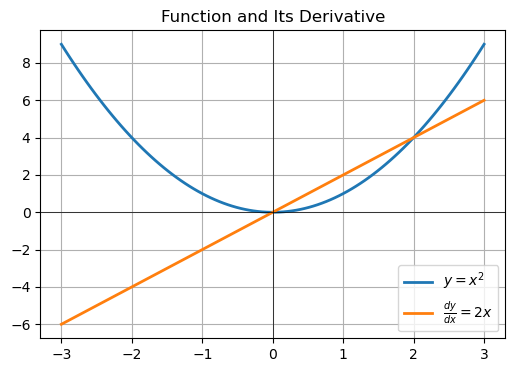

In [26]:
# Define x values
x = tf.constant(np.linspace(-3, 3, 100), dtype=tf.float32)

# Compute y = x^2 and its derivative
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2
dy_dx = tape.gradient(y, x)

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(x, y, label='$y = x^2$', linewidth=2)
plt.plot(x, dy_dx, label="$\\frac{dy}{dx} = 2x$", linewidth=2)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.title("Function and Its Derivative")
plt.show()

<a name="annex"></a>
## <font color='blue'> Annex </font>

<a name="A"></a>
### <font color='#1f618d'> A. WITH </font>

The **with** statement in Python is used to manage resources like files, network connections, or TensorFlow's GradientTape efficiently. It ensures proper setup and teardown, reducing the risk of resource leaks.

A **context manager** is a Python object that defines:
- ```__enter__()``` → Code that runs when entering the context (e.g., opening a file).
- ```__exit__()``` → Code that runs when exiting the context (e.g., closing the file).


Why Use with?
- It simplifies resource management by automatically handling cleanup, even if an error occurs.

In [35]:
with open('data.txt', 'r') as file:
    content = file.read()  # File is automatically closed after this block

# No need to explicitly call file.close() — Python handles it.

In [36]:
content

'some data\n'

In [37]:
# custom context manager
class CustomContext:
    def __enter__(self):
        print("Entering the context")
        return self  # Optional, often useful for object references

    def __exit__(self, exc_type, exc_value, traceback):
        print("Exiting the context")
        if exc_type:
            print(f"Error: {exc_value}")
        return True  # Suppresses the exception (not always recommended)

In [38]:
with CustomContext() as ctx:
    print("Inside the context")
    raise ValueError("Something went wrong!")  # Exception is suppressed

print("Continuing program...")

Entering the context
Inside the context
Exiting the context
Error: Something went wrong!
Continuing program...


In [39]:
#Alternative: contextlib for Simpler Context Managers
#The contextlib module provides an easier way to create context managers:

from contextlib import contextmanager

@contextmanager
def custom_context():
    print("Entering the context")
    yield
    print("Exiting the context")

with custom_context():
    print("Inside the context")


Entering the context
Inside the context
Exiting the context


**Key Use Cases:**

- File I/O (open())
- Database connections
- Thread locks
- TensorFlow’s GradientTape or PyTorch’s torch.no_grad()
- Temporary resource management

In short, `with` ensures clean, efficient code by automatically managing resources.

<a name="references"></a>
## <font color='blue'> References </font>

[TensorFlow Documentation](https://www.tensorflow.org/guide/autodiff)

[TensorFlow Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)

[Real Python - With](https://realpython.com/python-with-statement/)